One issue i observed with coregionalization is that the model can be overconfident. Let's see how we can work around this.

In [184]:
from __future__ import absolute_import

import os

import joblib
import numpy as np
import pandas as pd
from six.moves import range
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import wandb
from dispersant_screener.gp import (build_coregionalized_model, build_model, predict, predict_coregionalized)
from dispersant_screener.utils import (add_postfix_to_keys, get_metrics, get_variance_descriptors, plot_parity)
from dispersant_screener.definitions import FEATURES
from dispersant_screener.utils import get_maxmin_samples, get_kmeans_samples 


DATADIR = '../data'
TRAIN_SIZES = [0.005, 0.01, 0.05, 0.1, 0.5]
REPEAT = 5

df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv'))[FEATURES].values
a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
deltaGMax = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values
gibbs_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['deltaGmax'].values
force_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_fit2.csv'))['F_repel_max'].values
rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
y = np.hstack([
    rg.reshape(-1, 1),
    -1 * gibbs.reshape(-1, 1),
    gibbs_max.reshape(-1, 1),
])
assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)


In [185]:
vt = VarianceThreshold(0.2)
X = vt.fit_transform(df_full_factorial_feat)

feat_scaler = StandardScaler()
X = feat_scaler.fit_transform(X)

# label_scaler = StandardScaler()
# y = label_scaler.fit_transform(y)

X_train, y_train, greedy_indices = get_kmeans_samples(X, y, 20)


In [186]:
y_test = np.delete(y, greedy_indices, 0)
X_test = np.delete(X, greedy_indices, 0)

In [187]:
kern = GPy.kern.RBF(X_train.shape[1])

In [188]:
icm = GPy.util.multioutput.ICM(input_dim=X_train.shape[1], num_outputs=3, kernel=kern)

In [189]:
target_list = [y_train[:, i].reshape(-1, 1) for i in range(3)]

In [190]:
m = GPy.models.GPCoregionalizedRegression([X_train] * 3, target_list, kernel=icm)

In [191]:
m

gp.,value,constraints,priors
ICM.rbf.variance,1.0,+ve,
ICM.rbf.lengthscale,1.0,+ve,
ICM.B.W,"(3, 1)",,
ICM.B.kappa,"(3,)",+ve,
mixed_noise.Gaussian_noise_0.variance,1.0,+ve,
mixed_noise.Gaussian_noise_1.variance,1.0,+ve,
mixed_noise.Gaussian_noise_2.variance,1.0,+ve,


In [192]:
m['.*ICM.*.variance'].constrain_fixed(1.)

array([0])

In [193]:
m

gp.,value,constraints,priors
ICM.rbf.variance,1.0,+ve fixed,
ICM.rbf.lengthscale,1.0,+ve,
ICM.B.W,"(3, 1)",,
ICM.B.kappa,"(3,)",+ve,
mixed_noise.Gaussian_noise_0.variance,1.0,+ve,
mixed_noise.Gaussian_noise_1.variance,1.0,+ve,
mixed_noise.Gaussian_noise_2.variance,1.0,+ve,


In [194]:
m.optimize_restarts(20)

Optimization restart 1/20, f = 42.995746431636434
Optimization restart 2/20, f = 42.995742337496395
Optimization restart 3/20, f = 42.996076728757814
Optimization restart 4/20, f = 42.996042662836146
Optimization restart 5/20, f = 56.9311614834491
Optimization restart 6/20, f = 56.93109573266548
Optimization restart 7/20, f = 98.3850650823648
Optimization restart 8/20, f = 42.995785122296596
Optimization restart 9/20, f = 42.99574406440705
Optimization restart 10/20, f = 42.995742851699646
Optimization restart 11/20, f = 42.99574865286902
Optimization restart 12/20, f = 42.995742571762946
Optimization restart 13/20, f = 42.99587644113093
Optimization restart 14/20, f = 98.38506558883716
Optimization restart 15/20, f = 42.99574250387093
Optimization restart 16/20, f = 42.99576182981265
Optimization restart 17/20, f = 42.9957909583474
Optimization restart 18/20, f = 42.995748926035745
Optimization restart 19/20, f = 42.9958035478633
Optimization restart 20/20, f = 42.9957451867725


In [197]:
mu_0, var_0 = predict_coregionalized(m, X_test, 0)
mu_1, var_1 = predict_coregionalized(m, X_test, 1)

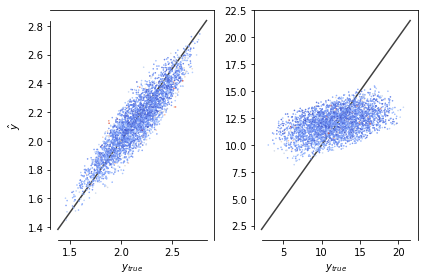

In [198]:
plot_parity([
    (y_test[:,0], mu_0, var_0), 
    (y_test[:,1], mu_1, var_1), 
])